In [1]:
import keras
import json
import pandas as pd
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Lambda, Reshape
from keras.utils import plot_model
from keras import metrics
from matplotlib import pyplot as plt
import random
import numpy as np

Using TensorFlow backend.


In [2]:
with open('business.json') as file:
    data = [json.loads(line) for line in file]
with open('photo.json') as file:
    photos = [json.loads(line) for line in file]

In [3]:
df = pd.DataFrame(data)
restaurants = df[df['categories'].str.contains('Restaurants').fillna(False)]
restaurants = restaurants[restaurants['review_count'] >= 50]
in_restaurants = {restaurants['business_id'].iloc[i] : True for i in range(len(restaurants))}

random.seed(0)
random.shuffle(photos)

In [4]:
MAX = 3774 * 2
high = 4.5
low = 2.5
X, y = [], [] 

count = [0, 0]
for photo in photos:
    if len(X) >= MAX:
        break
    name, photo_id = photo['business_id'], photo['photo_id']
    if photo['label'] != 'food' or name not in in_restaurants.keys():
        continue
    rating = restaurants[restaurants['business_id'] == name]['stars'].iloc[0]
    if (rating < high and rating > low) or count[int(rating >= high)] >= MAX/2:
        continue
    count[int(rating >= high)] += 1
    photo_array = imread('photos/' + photo_id + '.jpg')
    resized = resize(photo_array, (128, 128, 3), anti_aliasing = True)
    X.append(resized)
    y.append(float(rating >= high))
    
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

/home/mbper/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
def construct():
    image = Input(shape=(128, 128, 3))

    x1 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(image)
    x2 = MaxPooling2D(pool_size=2)(x1)
    x3 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(x2)
    x4 = MaxPooling2D(pool_size=2)(x3)
    x5 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(x4)
    encoded = MaxPooling2D(pool_size=2)(x5)

    y1 = UpSampling2D(size=2)(encoded)
    y2 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(y1)
    y3 = UpSampling2D(size=2)(y2)
    y4 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(y3)
    y5 = UpSampling2D(size=2)(y4)
    reconstructed = Conv2D(3, 3, strides=1, padding='same', activation = 'sigmoid')(y5)

    z1 = Conv2D(64, 3, strides=1, padding='same')(encoded)
    z2 = MaxPooling2D(pool_size=2)(z1)
    z3 = Conv2D(64, 3, strides=1, padding='same')(z2)
    z4 = MaxPooling2D(pool_size=2)(z3)
    z5 = Flatten()(z4)
    z6 = Dense(128, activation='relu')(z5)
    rating = Dense(1, activation='sigmoid')(z6)
    
    return (image, reconstructed, rating)

In [6]:
image, reconstructed, rating = construct()

autoencoder1 = Model(inputs = image, outputs = reconstructed)
autoencoder1.compile(optimizer='adadelta', loss='mean_squared_error')
for layer in autoencoder1.layers:
    layer.trainable = False
predictor1 = Model(inputs = image, outputs = rating)
predictor1.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Fit the autoencoder, then freeze the layers
autoencoder1.fit(X_train, X_train, batch_size=20, epochs=10)
predictor1.fit(X_train, y_train, batch_size=20, epochs=15)

Instructions for updating:
Use tf.cast instead.


/home/mbper/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/10
6793/6793 [==============================] - 191s 28ms/step - loss: 0.0306
Epoch 2/10
6793/6793 [==============================] - 189s 28ms/step - loss: 0.0163
Epoch 3/10
6793/6793 [==============================] - 191s 28ms/step - loss: 0.0139
Epoch 4/10
6793/6793 [==============================] - 187s 28ms/step - loss: 0.0128
Epoch 5/10
6793/6793 [==============================] - 190s 28ms/step - loss: 0.0118
Epoch 6/10
6793/6793 [==============================] - 192s 28ms/step - loss: 0.0112
Epoch 7/10
6793/6793 [==============================] - 192s 28ms/step - loss: 0.0106
Epoch 8/10
6793/6793 [==============================] - 192s 28ms/step - loss: 0.0100
Epoch 9/10
6793/6793 [==============================] - 193s 28ms/step - loss: 0.0097
Epoch 10/10
6793/6793 [==============================] - 191s 28ms/step - loss: 0.0095
Epoch 1/15
6793/6793 [==============================] - 27s 4ms/step - loss: 0.6126 - binary_accuracy: 0.6598
Epoch 2/15
6793/6793 [=======

In [14]:
predictor1.evaluate(X_test, y_test)[1]

755/755 [==============================] - 2s 3ms/step


0.7602649002675189

In [17]:
image, reconstructed, rating = construct()

autoencoder2 = Model(inputs = image, outputs = reconstructed)
autoencoder2.compile(optimizer='adadelta', loss='mean_squared_error')
predictor2 = Model(inputs = image, outputs = rating)
predictor2.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')

In [18]:
# Fit the autoencoder, but don't freeze the layers
autoencoder2.fit(X_train, X_train, batch_size=20, epochs=10)
predictor2.fit(X_train, y_train, batch_size=20, epochs=15)

Epoch 1/10
6793/6793 [==============================] - 215s 32ms/step - loss: 0.0310
Epoch 2/10
6793/6793 [==============================] - 188s 28ms/step - loss: 0.0167
Epoch 3/10
6793/6793 [==============================] - 188s 28ms/step - loss: 0.0143
Epoch 4/10
6793/6793 [==============================] - 188s 28ms/step - loss: 0.0129
Epoch 5/10
6793/6793 [==============================] - 187s 28ms/step - loss: 0.0120
Epoch 6/10
6793/6793 [==============================] - 187s 28ms/step - loss: 0.0112
Epoch 7/10
6793/6793 [==============================] - 188s 28ms/step - loss: 0.0105
Epoch 8/10
6793/6793 [==============================] - 190s 28ms/step - loss: 0.0101
Epoch 9/10
6793/6793 [==============================] - 185s 27ms/step - loss: 0.0097
Epoch 10/10
6793/6793 [==============================] - 187s 28ms/step - loss: 0.0095
Epoch 1/15
6793/6793 [==============================] - 69s 10ms/step - loss: 0.6330 - binary_accuracy: 0.6393
Epoch 2/15
6793/6793 [======

In [19]:
predictor2.evaluate(X_test, y_test)[1]

755/755 [==============================] - 3s 4ms/step


0.7390728472873864

In [24]:
image, reconstructed, rating = construct()

predictor3 = Model(inputs = image, outputs = rating)
predictor3.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')
for layer in predictor3.layers:
    layer.trainable = False
autoencoder3 = Model(inputs = image, outputs = reconstructed)
autoencoder3.compile(optimizer='adadelta', loss='mean_squared_error')

In [25]:
predictor3.fit(X_train, y_train, batch_size=20, epochs=15)
autoencoder3.fit(X_train, X_train, batch_size=20, epochs=10)

Epoch 1/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.6653 - binary_accuracy: 0.5856
Epoch 2/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.6042 - binary_accuracy: 0.6663
Epoch 3/15
6793/6793 [==============================] - 70s 10ms/step - loss: 0.5436 - binary_accuracy: 0.7197
Epoch 4/15
6793/6793 [==============================] - 70s 10ms/step - loss: 0.4701 - binary_accuracy: 0.7748
Epoch 5/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.3766 - binary_accuracy: 0.8298
Epoch 6/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.2783 - binary_accuracy: 0.8788
Epoch 7/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.1723 - binary_accuracy: 0.9314
Epoch 8/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.0912 - binary_accuracy: 0.9635
Epoch 9/15
6793/6793 [==============================] - 71s 10ms/step - loss: 0.0421 - binary_accuracy: 0.9868
E

In [27]:
predictor3.evaluate(X_test, y_test)[1]

755/755 [==============================] - 3s 4ms/step


0.7496688747248113

In [ ]:
image, reconstructed, rating = construct()

mixed = Model(inputs = image, outputs = [rating, reconstructed])
mixed.compile(optimizer='adadelta', loss=['binary_crossentropy', 'mean_squared_error'], loss_weights = [1., 100.])

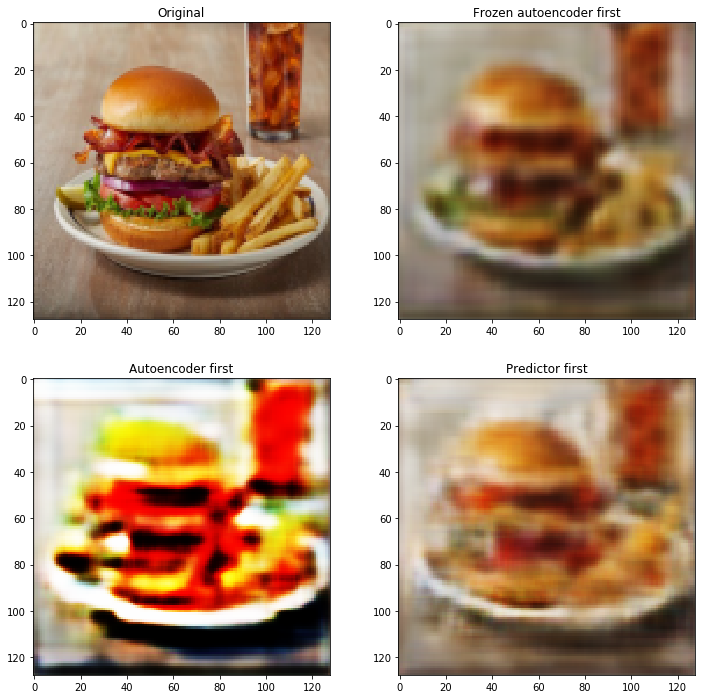

In [73]:
N = 10
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.imshow(X_test[N])
ax2.imshow(autoencoder1.predict(X_test[N:N+1])[0])
ax3.imshow(autoencoder2.predict(X_test[N:N+1])[0])
ax4.imshow(autoencoder3.predict(X_test[N:N+1])[0])
ax1.set_title("Original")
ax2.set_title("Frozen autoencoder first")
ax3.set_title("Autoencoder first")
ax4.set_title("Predictor first")
fig.show()